<a href="https://colab.research.google.com/github/Hohlas/Nero/blob/main/fx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install mpl_finance
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc

подключение TPU в Colab

In [2]:
import tensorflow as tf
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)


In [3]:
# Загрузка данных из файла
history_data = 'https://drive.google.com/uc?id=1_eYsMYv8L_rrFrNnVN39ugbSVvC12Mm5'
data = pd.read_csv(history_data, header=None, sep=',', names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])
data = data.tail(400) # Выбор последних 100 строк

Text(0.5, 1.0, 'High-Low Bar Chart')

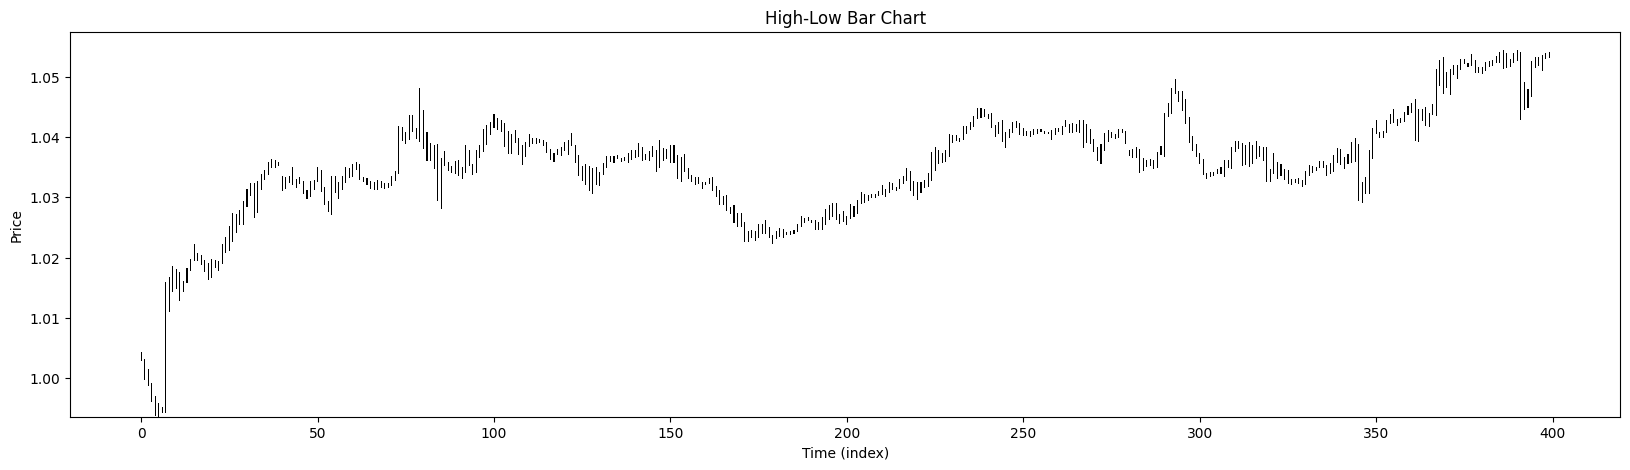

In [43]:
# Выбираем только столбцы 'high' и 'low'
data_hl = data[['high', 'low']]
fig, ax = plt.subplots()
# Строим бары по высоте
ax.bar(range(len(data_hl)), data_hl['high'] - data_hl['low'], bottom=data_hl['low'], width=0.3, color='black')
fig.set_size_inches(20, 5)# Установка размера окна
ax.set_xlabel('Time (index)')
ax.set_ylabel('Price')
ax.set_title('High-Low Bar Chart')

Я опытный программист и трейдер. Пишу программы для автоматической торговли на валютном рынке. Мне потребовалось написать торговый робот на базе нейронной сети. Но я никогда не использовал нейронные сети в своих программах и не имею опыта работы с ними. Скажи пожалуйста, какую нейронную сеть лучше использовать для прогнозирования временных рядов, в частности для финансовых рынков форекс. Опиши подробно, но простым языком как нужно взаимодействовать с библиотекой нейронной сети, какие данные подавать на вход, как их подготавливать, что учитывать при обработке входных данных ?


---


*лучше всего подходят рекуррентные нейронные сети (RNN). Они хорошо работают с последовательными данными и учитывают зависимости между предыдущими и текущими значениями.
Конкретнее, рекомендую использовать LSTM (долгая краткосрочная память) - это усовершенствованный вид RNN, который может учиться долгосрочным зависимостям(Keras, PyTorch, TensorFlow). На вход подаём подготовленные последовательности цен, выход - прогноз на следующий шаг. Используем алгоритм обратного распространения ошибки*.


---


Да, приведи пожалуйста пример кода. В качестве входных данных предлагаю использовать массив из последних 100 значений ценового ряда

data_hl = data[['high', 'low']]. Будем считать, что ряд data[['high', 'low']] содержит цены High и Low часового таймфрейма за последние 10 лет. Но мне не требуется прогноз на каждом баре. Лучше определять определенные моменты входа - точки, в которых цена с высокой вероятностью поменяет свое направление. Чтобы соотношение Profit/Loss в этих точках было максимальным. Достаточно, чтобы точки входа формировались в среднем с интервалом 20 - 30 бар.

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Загрузка и normalizация  данных
#data = pd.read_csv('data.csv')
history_data = 'https://drive.google.com/uc?id=1_eYsMYv8L_rrFrNnVN39ugbSVvC12Mm5'
data = pd.read_csv(history_data, header=None, sep=',', names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])
data = data[['high', 'low']]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Преобразуем данные в последовательности
X = [] # набор входных последовательностей
y = [] # ответы для обучения
seq_size = 100 # кол-во бар для предсказания (анализируем предыдущие 100 цен и предсказываем 101-ю)
for i in range(seq_size, len(data_scaled)):
  X.append(data_scaled[i-seq_size:i])
  y.append(data_scaled[i, 0]) # 0 - индекс изменения направления
X, y = np.array(X), np.array(y) # Преобразуем списки в numpy массивы
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, y_train - данные для обучения модели
# X_val, y_val - валидационные данные для оценки модели во время обучения
# test_size=0.2 означает, что на валидацию мы берем 20% от исходных данных, а на обучение - оставшиеся 80%
# random_state фиксирует случайную выборку, чтобы результаты были воспроизводимы

# Определяем архитектуру LSTM
with strategy.scope():
  # создаем модель
  model = Sequential()
  model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(1, activation='sigmoid'))
  # Компилируем модель
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
  # Обучаем с batchsize=64 (размер группы данных, по которым обновляются веса на каждой итерации). Меньший размер дает точность, больший - скорость обучения
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)
  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, callbacks=[early_stopping])

# Прогноз следующей точки разворота
x_new = np.reshape(data_scaled[-seq_size:], (1, seq_size, 2))
y_pred = model.predict(x_new)
if y_pred > 0.5:
   print("Predicted reversal point")
# В данном примере метки классов (y) - это флаг изменения направления цены. На выходе LSTM отдает вероятность разворота от 0 до 1, по которой можно отфильтровывать значимые сигналы.

Epoch 1/100
1941/1941 [==============================] - 80s 36ms/step - loss: 0.6152 - val_loss: 0.6151
Epoch 2/100
1941/1941 [==============================] - 65s 33ms/step - loss: 0.6147 - val_loss: 0.6150
Epoch 3/100
1941/1941 [==============================] - 65s 33ms/step - loss: 0.6147 - val_loss: 0.6151
Epoch 4/100
1941/1941 [==============================] - 65s 34ms/step - loss: 0.6146 - val_loss: 0.6149
Epoch 5/100
1941/1941 [==============================] - 65s 33ms/step - loss: 0.6146 - val_loss: 0.6149
Epoch 6/100
1941/1941 [==============================] - 70s 36ms/step - loss: 0.6146 - val_loss: 0.6149
Epoch 7/100
1941/1941 [==============================] - 66s 34ms/step - loss: 0.6146 - val_loss: 0.6149
Epoch 8/100
1941/1941 [==============================] - 65s 33ms/step - loss: 0.6146 - val_loss: 0.6152
Epoch 9/100
1941/1941 [==============================] - 66s 34ms/step - loss: 0.6146 - val_loss: 0.6149
Epoch 10/100
1941/1941 [==============================]